# Introduction To Probability \& Statistics: I

*N. Hernitschek, 2022*

This is the third Jupyter notebook for **ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)**. 
This Jupyter notebook gives an introduction to probability and statistics with a focus on describing and fitting data similar to those from astronomical surveys.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray.

***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Descriptive Statistics](#first-bullet)
* [Physical Models](#second-bullet)
* [Summary](#third-bullet)

We can summarize the goal of this lecture as:

1) estimate the empirical pdf $f(x)$ from some real (possibly multi-dimensional) data set, 

2) find a way to describe $f(x)$ and its uncertainty, 

3) compare it to models of the underlying probability distribution $h(x)$, to finally

4) use the knowledge that we have gained to interpret new measurements.

## 1. Descriptive Statistics <a class="anchor" id="first-bullet"></a>

Our goal is to estimate $h(x)$ given some measured data, allowing us to reconstruct the empirical distribution $f(x)$. An arbitrary distribution can be characterized by **location** parameters (i.e., position), **scale** parameters (i.e., width), and **shape** parameters. These parameters are called ***descriptive statistics***.

The distribution we're trying to characterize could be anything, e.g. (in astronomy) the distribution of distances of stars.

Python offers many built-in functions for descriptive statistics in its `scipy.stats` package.

In [1]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

In [2]:
# Execute this cell
#------------------------------------------------------------
# Let's generate some data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * scipy.stats.cauchy(mu, gamma).pdf(x)
                    for (mu, gamma, f) in mu_gamma_f])
data = np.concatenate([scipy.stats.cauchy(mu, gamma).rvs(int(f * N), 
                                                         random_state=random_state)
                       for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(data)
data = data[data > -10]
data = data[data < 30]

Text(0, 0.5, '$f(x)$')

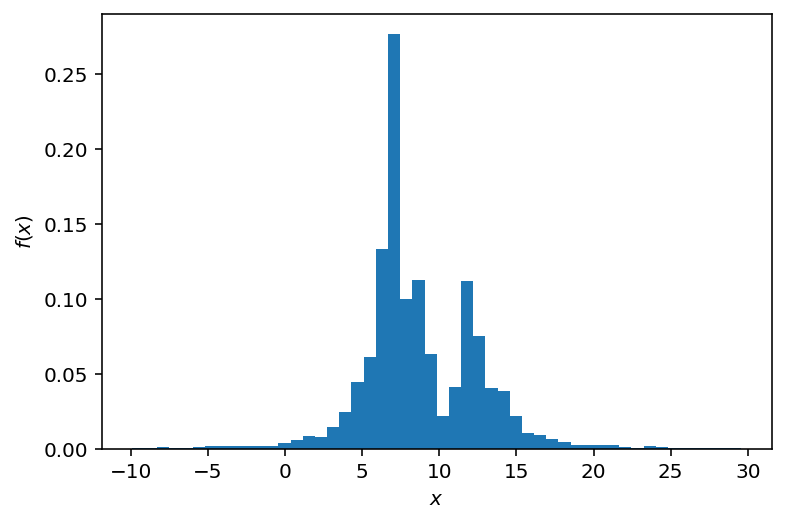

In [3]:
# Execute this cell
# make a histogram to get an idea of what the distribution looks like
plt.hist(data, bins=50, density=True)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [4]:
# Execute this cell
mean = np.mean(data)
print(mean)

8.707331724932475


The **mean** of a sample is 

$$\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i$$ 

This is actually known as the **sample arithmetic mean**, and derives from *Monte Carlo integration* to get the first moment of the distribution, i.e. 

$$\mu = E(x) = \langle x \rangle = \int_{-\infty}^{\infty} x h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N x_i $$

where $\{x_i\}$ are random samples from the properly normalzied $h(x)$, and $E(\cdot)$ means the **expectation value**. In general we can use random sampling and Monte Carlo integration to deduce integrals over distributions such that 

$$\int_{-\infty}^{\infty} g(x) h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N g(x_i)$$

(We will learn later on what e.g. random sampling, Monte Carlo integration mean in detail.)

<font color='red'>Does the mean describe the distribution (in the plot) well?</font>

No it does not. You would expect most of the values to be right around the mean, but this is not the case. The values vary from 0 to 20.

Despite a mean sounds intuitive, some distributions do not have formally calculable means (as integration gives infinity). In these and other cases, the **median** is a more *robust* estimator of the (true) "mean" location of the distribution. That's because it is less affected by **outliers**.

To understand the previous statement, think about multiplying all numbers above the 50th percentile (i.e. the median) by 100, or even just replacing them with larger numbers. The mean would be strongly affected by these corrupted points, but **cumulative statistics based on the ordering of samples would remain unaffected by the outlier corruption**.

<font color='red'>Execute the next cell. Think about and discuss what it is doing.</font>

In [5]:

median = np.median(data)

mask = data > 15
data2 = data.copy()
data2[mask] = 100

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.665858989040229 7.665858989040229
8.707331724932475 12.230618259322716


Median is less sensitive to outliers.

## 2. Physical Models <a class="anchor" id="second-bullet"></a>

In the lecture, we have seen that we can either:
* Describe the data, then the process is non-parametric, i.e. we are just trying to describe the data behavior in a compact practical way.
* Guess a physical model for $h(x)$, then the process is parametric. From a model we can generate new data that mimic measurements. 

<font color='red'>**Execute the following code cell.**</font>
This cell produces a figure similar to the one from the lecture. 
The code will start with a generating distribution $h(x)$, draw a number of random samples as data $\{x_i\}$, and then fit these data with a parametric and non-parametric model $f(x)$.


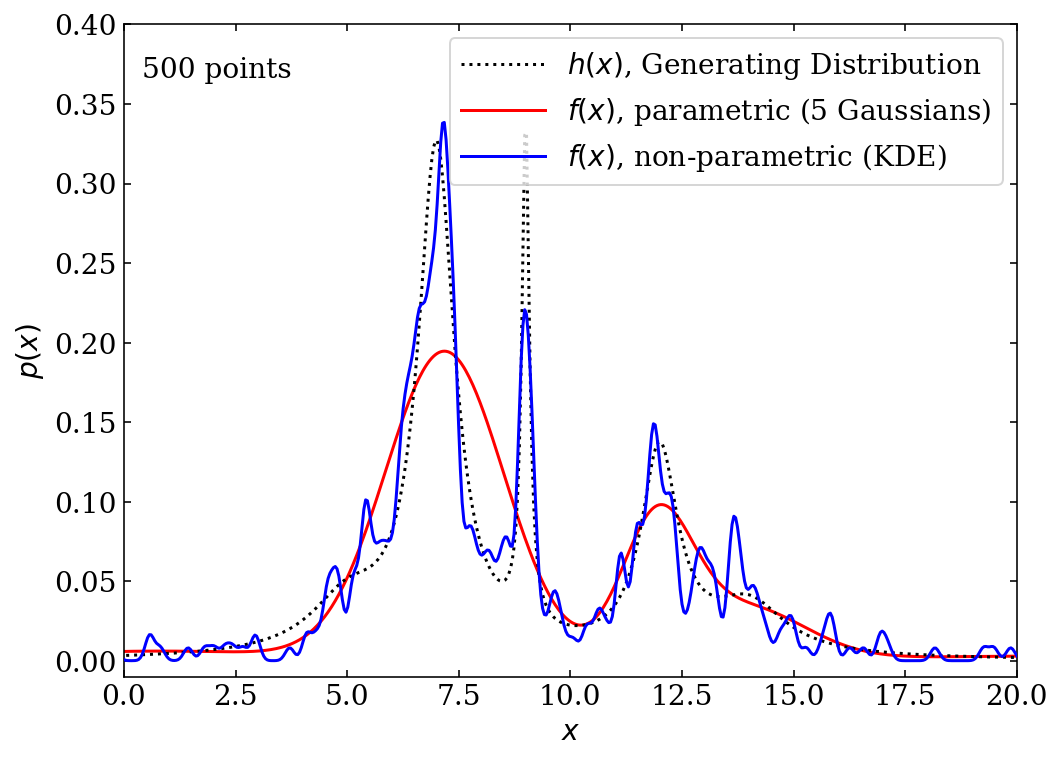

In [9]:
# based on Ivezic v2, Figure 6.8; edited by G. T. Richards and S. R. Taylor

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astropy.visualization import hist
from sklearn.mixture import GaussianMixture

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=False)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 500 # number of data points
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N), random_state=random_state)
                    for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig,ax = plt.subplots(figsize=(8, 6))

xgrid = np.linspace(-10, 30, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(x[:, None])
dens_kde = np.exp(kde.score_samples(xgrid[:, None]))

# Compute density via Gaussian Mixtures using a pre-defined number of clusters (13)
comp = 5
gmm = GaussianMixture(n_components=comp).fit(x.reshape(-1, 1))
logprob = gmm.score_samples(xgrid.reshape(-1, 1))
fx = lambda j : np.exp(gmm.score_samples(j.reshape(-1, 1)))

# plot the results
ax.plot(xgrid, hx(xgrid), ':', color='black', zorder=3,
            label="$h(x)$, Generating Distribution")
ax.plot(xgrid, fx(np.array(xgrid)), '-', color='red',
            label="$f(x)$, parametric ("+str(comp)+" Gaussians)")
ax.plot(xgrid, dens_kde, '-', color='blue', zorder=3,
            label="$f(x)$, non-parametric (KDE)")

# label the plot
ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
ax.set_ylabel('$p(x)$',fontsize=14)
ax.legend(loc='upper right')

ax.set_xlabel('$x$',fontsize=14)
ax.set_xlim(0, 20)
ax.set_ylim(-0.01, 0.4001)

plt.show()

## Summary <a class="anchor" id="third-bullet"></a>

At this point, all of you should have:
* learnt how to use built-in functions for descriptive statistics from Python's `scipy.stats` package
* seen a basic comparison of descriptive statistics vs. model fitting.